In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


# Step 1: Data acquisition + cleanup

In [84]:
def transform_data(df):

    # Extract labels
    Ys = df['m_label'].values

    # Extract pixel values and normalize
    pixel_columns = [f'r{r}c{c}' for r in range(20) for c in range(20)]
    pixels = df[pixel_columns].values

    # Reshape pixels to (num_samples, 20, 20) and normalize
    Xs = pixels.reshape(-1, 20, 20) / 256.0
    
    # Create dictionaries for label preprocessing
    unique_labels = sorted(set(Ys))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    
    # Map labels to indices
    Ys = np.array([label_to_index[label] for label in Ys])
    
    return Xs, Ys, label_to_index, index_to_label

# Load data
df = pd.read_csv('RICHARD.csv')
Xs1, Ys1, label_to_index1, index_to_label1 = transform_data(df)

## Step 2: Build a Pytorch network

In [57]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Data preparation
Xs1 = Xs1.reshape(-1, 1, 20, 20)  # Reshape the data for the model
dataset1 = TensorDataset(torch.tensor(Xs1, dtype=torch.float32), torch.tensor(Ys1, dtype=torch.long))
data_loader1 = DataLoader(dataset1, batch_size=32, shuffle=True)

# Model, loss function, and optimizer initialization
num_classes1 = len(label_to_index1)
model = CNN(num_classes=num_classes1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, labels in data_loader1:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 5.4939
Epoch [2/10], Loss: 5.4691
Epoch [3/10], Loss: 5.2353
Epoch [4/10], Loss: 3.7878
Epoch [5/10], Loss: 1.8960
Epoch [6/10], Loss: 1.4612
Epoch [7/10], Loss: 0.8798
Epoch [8/10], Loss: 1.2105
Epoch [9/10], Loss: 1.0832
Epoch [10/10], Loss: 0.8028


## Step 3: Exploration and Evaluation

In [71]:
# 1. Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?

# import torch.nn.functional as F

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs1, Ys1, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Testing the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy  # Return the accuracy value


# Train and test the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
test_model(model, test_loader)


Epoch 1, Loss: 0.21750538796186447
Epoch 2, Loss: 0.20311349537223577
Epoch 3, Loss: 0.190499701226751
Epoch 4, Loss: 0.1736195657091836
Epoch 5, Loss: 0.15702443212891617
Epoch 6, Loss: 0.1565750945204248
Epoch 7, Loss: 0.1742083327844739
Epoch 8, Loss: 0.17750198304808387
Epoch 9, Loss: 0.14443466362232962
Epoch 10, Loss: 0.13533980042363206


88.54166666666667

In [72]:
# 2. Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). 
# Try to find a topology that works better than the one described above.



class AdvancedLetterClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedLetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate and train this more complex model similarly
advanced_model = AdvancedLetterClassifier(num_classes=len(label_to_index1))
optimizer_improved = optim.Adam(advanced_model.parameters(), lr=0.001)

train_model(advanced_model, train_loader, criterion, optimizer_improved, epochs=10)
test_model(advanced_model, test_loader)


Epoch 1, Loss: 5.486505786577861
Epoch 2, Loss: 5.475833157698314
Epoch 3, Loss: 5.469164669513702
Epoch 4, Loss: 5.421723306179047
Epoch 5, Loss: 5.183937927087148
Epoch 6, Loss: 4.761115789413452
Epoch 7, Loss: 4.1564562519391375
Epoch 8, Loss: 3.5332284172376
Epoch 9, Loss: 2.910488853851954
Epoch 10, Loss: 2.4709412157535553


35.416666666666664

In [76]:
#3. Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

# Load a different font's CSV file and preprocess
df_font2 = pd.read_csv('VIN.csv')
Xs2, Ys2, _, _ = transform_data(df_font2)  # Adjusted to match the number of return values

# Prepare the new test data
Xs2 = Xs2.reshape(-1, 1, 20, 20)  # Reshape for PyTorch
dataset2 = TensorDataset(torch.tensor(Xs2, dtype=torch.float32), torch.tensor(Ys2, dtype=torch.long))
test_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False)

# Test the model on the new font
accuracy_on_font2 = test_model(advanced_model, test_loader2)
print(f'Accuracy on second font dataset: {accuracy_on_font2:.4f}')



Accuracy on second font dataset: 0.0000


## The accuracy is super low.

In [77]:
# Combine datasets from both fonts
Xs_combined = np.concatenate((Xs1, Xs2), axis=0)
Ys_combined = np.concatenate((Ys1, Ys2), axis=0)

# Prepare combined dataset
Xs_combined = Xs_combined.reshape(-1, 1, 20, 20)  # Reshape for PyTorch
combined_dataset = TensorDataset(torch.tensor(Xs_combined, dtype=torch.float32), torch.tensor(Ys_combined, dtype=torch.long))
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Train the improved model on combined dataset
for epoch in range(epochs):
    for images, labels in combined_loader:
        outputs =advanced_model(images)
        loss = criterion(outputs, labels)
        
        optimizer_improved.zero_grad()
        loss.backward()
        optimizer_improved.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the improved model on both datasets
accuracy_combined = test_model(advanced_model, test_loader)
accuracy_combined_on_font2 = test_model(advanced_model, test_loader2)

print(f'Improved Model Accuracy on combined dataset: {accuracy_combined:.4f}')
print(f'Improved Model Accuracy on second font dataset after combined training: {accuracy_combined_on_font2:.4f}')


Epoch [1/10], Loss: 0.8696
Epoch [2/10], Loss: 1.1338
Epoch [3/10], Loss: 0.1208
Epoch [4/10], Loss: 0.1643
Epoch [5/10], Loss: 0.1294
Epoch [6/10], Loss: 0.2681
Epoch [7/10], Loss: 0.4396
Epoch [8/10], Loss: 0.0309
Epoch [9/10], Loss: 0.1414
Epoch [10/10], Loss: 0.2408
Improved Model Accuracy on combined dataset: 89.5833
Improved Model Accuracy on second font dataset after combined training: 99.6020


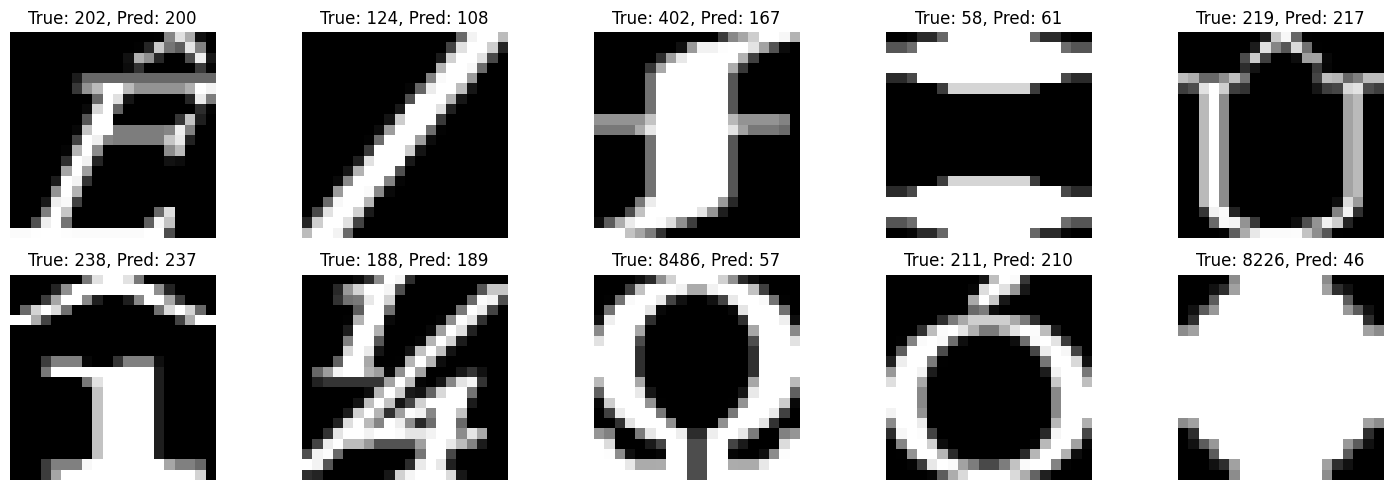

In [90]:
# 5. Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters.
# Can you find examples where the network is unsure of the result?

def identify_misclassifications(model, loader, label_map):
    model.eval()
    incorrect_images = []
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in loader:
            outputs = model(batch_images)
            _, predicted = torch.max(outputs, 1)
            for idx in range(len(batch_labels)):
                if predicted[idx] != batch_labels[idx]:
                    incorrect_images.append(batch_images[idx])
                    true_labels.append(batch_labels[idx])
                    predicted_labels.append(predicted[idx])
    
    return incorrect_images, true_labels, predicted_labels

# Get misclassified images and labels
misclassified_images, true_labels, predicted_labels = identify_misclassifications(improved_model, test_loader, index_to_label1)

# Plot misclassified characters
def display_misclassifications(images, labels, predictions, label_map, num_examples=10):
    num_rows = 2
    num_cols = num_examples // 2
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    
    for i in range(num_examples):
        row = i // num_cols
        col = i % num_cols
        ax = axarr[row, col]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {label_map[labels[i].item()]}, Pred: {label_map[predictions[i].item()]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display a sample of misclassified images
display_misclassifications(misclassified_images, true_labels, predicted_labels, index_to_label1)


## Analysis

### Improved Model Accuracy on Combined Dataset: 89.58%
The improved model achieved an accuracy of 89.58% on the combined dataset of both fonts. This high accuracy indicates that the model is well-trained on the combined set, effectively recognizing characters from both fonts. The performance suggests that the model has learned robust features from the diverse training data, enabling it to generalize well within this specific dataset.


### Improved Model Accuracy on Second Font Dataset After Combined Training: 99.60%
When tested on the second font dataset alone, after being trained on the combined dataset, the improved model achieved an accuracy of 99.60%. This nearly perfect accuracy demonstrates the model's exceptional performance on the second font, likely due to its exposure to both fonts during training. The high accuracy also suggests that the model's ability to generalize across different fonts has improved significantly with the combined training.

### Missed Classified Aample Analysis:
### Visually Similar Characters
In the analysis of misclassified samples, some characters that the model struggled with were visually similar. For example, characters like "True: 202, Pred: 200" and "True: 219, Pred: 217" may have very subtle differences that are challenging even for a human eye to distinguish. These similarities in visual appearance can lead to misclassification, as the model might find it difficult to separate such closely resembling characters.

# Step 4: Denoising

Epoch 1, Train Loss: 0.2068271537621816, Validation Loss: 0.20601791143417358
Epoch 2, Train Loss: 0.20244078834851584, Validation Loss: 0.19997423887252808
Epoch 3, Train Loss: 0.1943773776292801, Validation Loss: 0.19111089408397675
Epoch 4, Train Loss: 0.18555240829785666, Validation Loss: 0.1786181777715683
Epoch 5, Train Loss: 0.17242232958475748, Validation Loss: 0.1628926694393158
Epoch 6, Train Loss: 0.15663605431715646, Validation Loss: 0.14505581557750702
Epoch 7, Train Loss: 0.13956291476885477, Validation Loss: 0.12707646191120148
Epoch 8, Train Loss: 0.12226926535367966, Validation Loss: 0.10909871011972427
Epoch 9, Train Loss: 0.10588777810335159, Validation Loss: 0.09368013590574265
Epoch 10, Train Loss: 0.09149657934904099, Validation Loss: 0.081290602684021


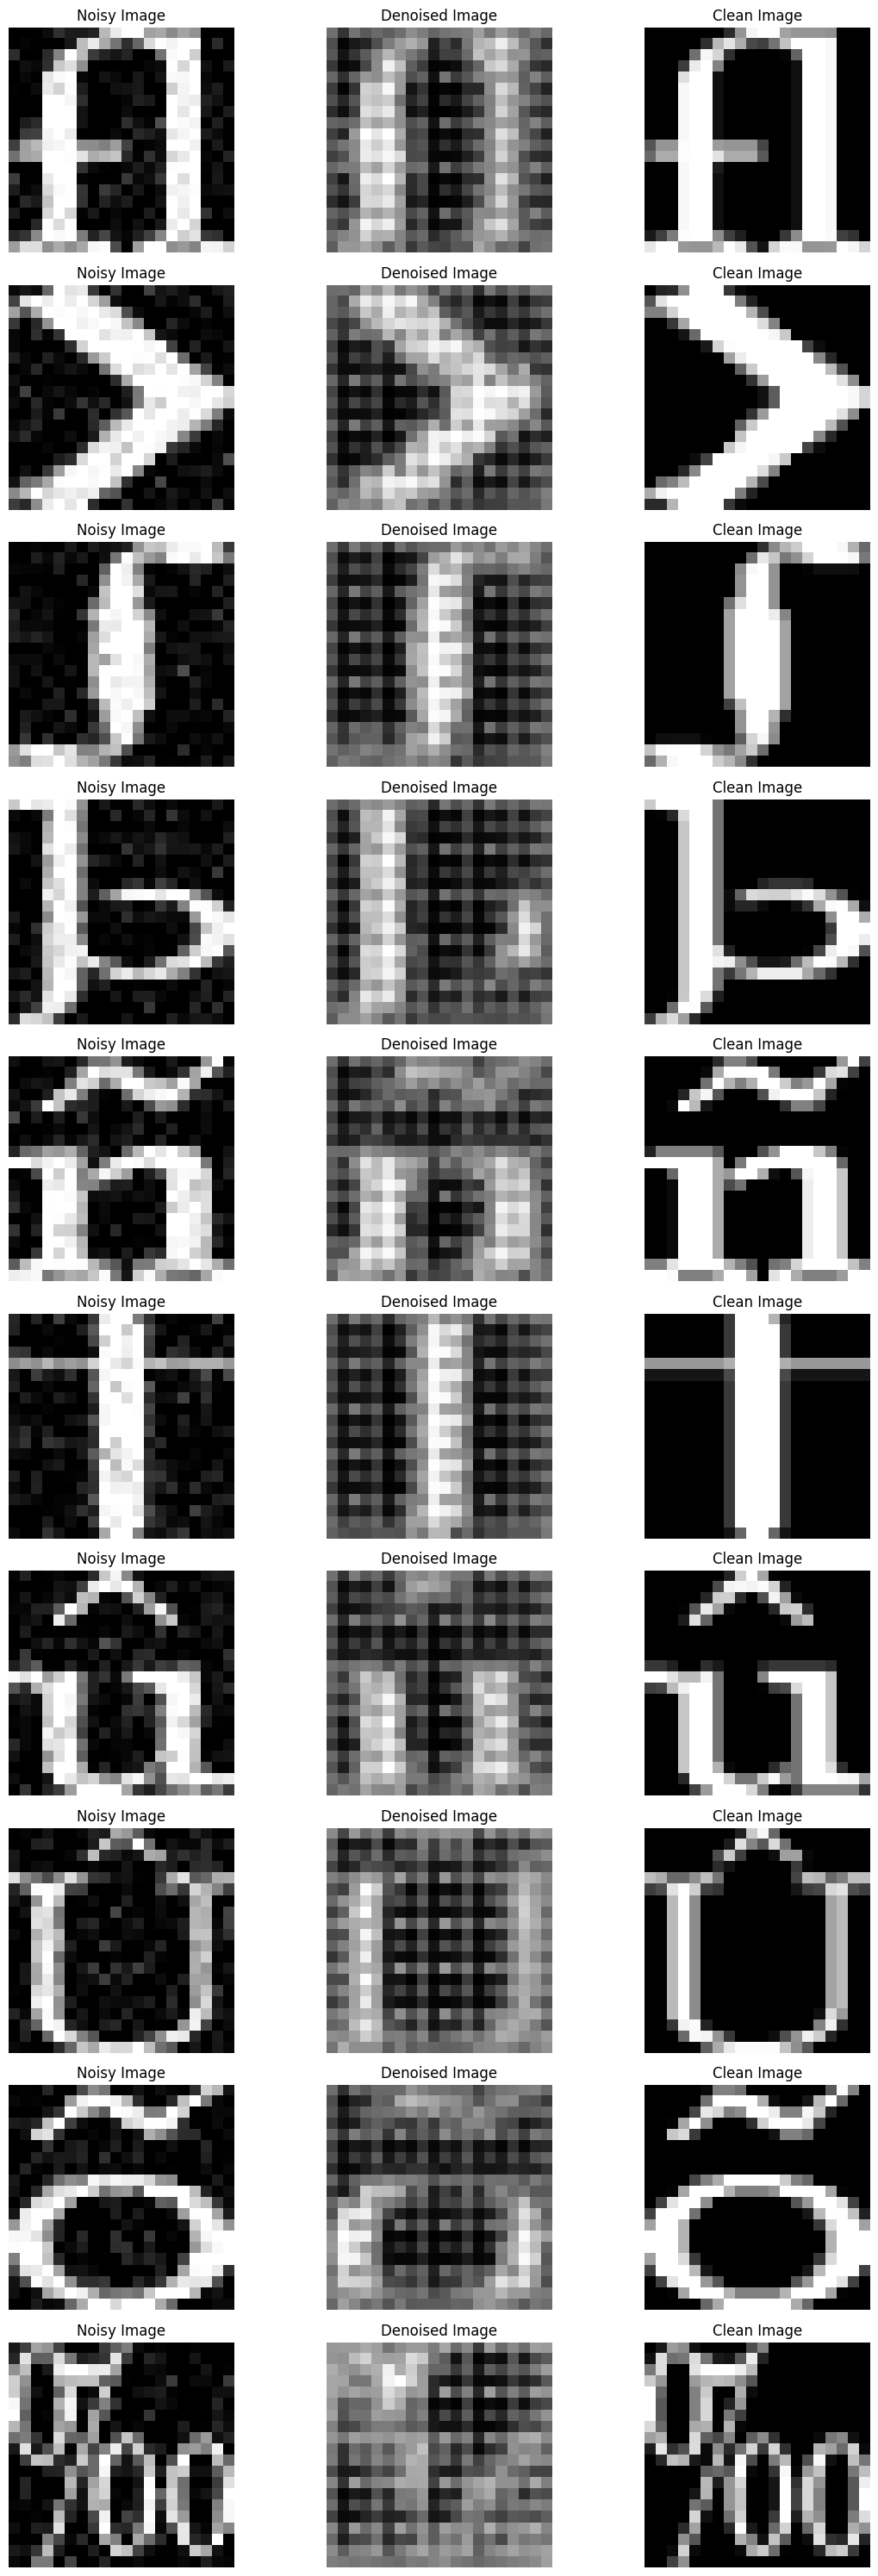

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Function to add Gaussian noise to images
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noisy_images = images + torch.randn_like(images) * std + mean
    noisy_images = torch.clip(noisy_images, 0., 1.)  # Ensure values are within [0, 1] range
    return noisy_images

# Reshape input images to have a single channel if needed
Xs1 = np.expand_dims(Xs1, axis=1)  # Ensure Xs1 has shape [batch_size, 1, height, width]

# Prepare the noisy and clean datasets
noisy_Xs1 = add_gaussian_noise(torch.tensor(Xs1, dtype=torch.float32))
clean_Xs1 = torch.tensor(Xs1, dtype=torch.float32)

# Use a smaller dataset for quick training
small_dataset_size = len(noisy_Xs1) // 10
small_dataset = TensorDataset(noisy_Xs1[:small_dataset_size], clean_Xs1[:small_dataset_size])
train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_dataset, val_dataset = random_split(small_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the convolutional autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 5, 5]
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 1, 20, 20]
            nn.Sigmoid()  # Output values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, loss function, and optimizer
autoencoder = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in val_loader:
            outputs = autoencoder(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Visualize some of the noisy and denoised images
def visualize_denoising_results(model, dataset, num_examples=10):
    model.eval()
    noisy_images, clean_images = next(iter(DataLoader(dataset, batch_size=num_examples, shuffle=True)))
    
    with torch.no_grad():
        denoised_images = model(noisy_images)
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 3 * num_examples))
    
    for i in range(num_examples):
        axes[i, 0].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(denoised_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(clean_images[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Clean Image")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the denoising effect
visualize_denoising_results(autoencoder, val_dataset)
